In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_test = lob.load_prepared_data(
        s, data_dir='../data/prepared', length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
print('Dates of datasets')
for s in stocks:
    print(s)
    print('training', min(d_stocks[s].index), '-', max(d_stocks[s].index))
    print('testing', min(d_test_stocks[s].index), '-', max(d_test_stocks[s].index))

Dates of datasets
9061
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00
3459
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00
4549
training 2013-09-02 08:30:00 - 2013-10-30 12:48:00
testing 2013-10-30 12:49:00 - 2013-11-14 10:08:00
9761
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00
4851
training 2013-09-02 08:30:00 - 2013-10-30 12:52:00
testing 2013-10-30 12:53:00 - 2013-11-14 10:12:00
9062
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00
11869
training 2013-09-02 08:30:00 - 2013-10-30 12:53:00
testing 2013-10-30 12:54:00 - 2013-11-14 10:13:00
12255
training 2013-09-02 08:30:00 - 2013-10-30 12:51:00
testing 2013-10-30 12:52:00 - 2013-11-14 10:14:00
2748
training 2013-09-02 08:30:00 - 2013-10-30 12:51:00
testing 2013-10-30 12:52:00 - 2013-11-14 10:10:00
4320
training 2013-09-02 0

## Logistic regression on queue imbalance feature


In [5]:
from sklearn import utils
def get_classes_weights(df):
    y_train = df['mid_price_indicator'].values
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

In [6]:
def get_scores_dict_for_data(functions_to_run, dfs, clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = LogisticRegression(random_state=0, class_weight=get_classes_weights(d_stocks[stock])) #21312)
    res_train = model.validate_model(log_clf, d_stocks[stock][['queue_imbalance']], 
                         d_stocks[stock]['mid_price_indicator'])
    dfs = {'test': d_test_stocks[stock]}
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    d_stocks[stock]['pred_log'] = log_clf.predict(d_stocks[stock][['queue_imbalance']])

    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [7]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
9061,0.507121,0.094602,0.095738,0.485178,0.536079,0.547950,9061,0.511161,0.089713,0.090966,...,0.084134,0.474847,0.550240,0.542446,"[0.5003092911047878, 0.48793634496919913, 0.49...","[0.07275227788965855, 0.0761604535558511, 0.08...","[0.0733284992740886, 0.07638647672456578, 0.08...","[0.46870653685674546, 0.46799606105366814, 0.4...","[0.5364818254178827, 0.5096514745308312, 0.516...","[0.5370060458808542, 0.5385094209490993, 0.540..."
3459,0.344387,0.092428,0.120196,0.236054,0.641646,0.576229,3459,0.352005,0.112207,0.130774,...,0.129963,0.250888,0.600319,0.581691,"[0.36654569449026725, 0.371033360455655, 0.361...","[0.11206933746230985, 0.11422034093170752, 0.1...","[0.1383540326726628, 0.14171977601535152, 0.14...","[0.2584321935333799, 0.2612282309807516, 0.257...","[0.6301758366420873, 0.6400898371701291, 0.605...","[0.5861307221130574, 0.5879020614422075, 0.588..."
4549,0.435926,0.112035,0.122816,0.348114,0.586051,0.567216,4549,0.430924,0.123603,0.133548,...,0.119528,0.348725,0.569006,0.565663,"[0.4273014916377882, 0.4255255255255255, 0.427...","[0.10553134626982785, 0.10182457803431133, 0.1...","[0.11328400925629142, 0.10955769730021216, 0.1...","[0.3466145196773405, 0.34426627793974734, 0.34...","[0.5569520816967792, 0.5569968553459119, 0.549...","[0.5621789053895775, 0.5601680604184665, 0.571..."
9761,0.428456,0.140536,0.146427,0.363742,0.523900,0.579966,9761,0.436612,0.099671,0.107514,...,0.125276,0.355845,0.572359,0.568539,"[0.4509911894273127, 0.4249655805415329, 0.408...","[0.10526650074146915, 0.10701413455414643, 0.1...","[0.11700738710866163, 0.11404332075676671, 0.1...","[0.355700325732899, 0.3475975975975976, 0.3449...","[0.6160210605490786, 0.5466351829988194, 0.501...","[0.5634506885336886, 0.5625316924049725, 0.563..."
4851,0.290029,0.103769,0.141509,0.189234,0.631029,0.602119,4851,0.287706,0.103878,0.138680,...,0.146122,0.208106,0.611383,0.601755,"[0.3206958805186279, 0.32526881720430106, 0.32...","[0.09425063903595143, 0.10250756204922207, 0.1...","[0.133946046494205, 0.14240065482781297, 0.159...","[0.20920770877944325, 0.21373371605210864, 0.2...","[0.6865776528460998, 0.6802529866479269, 0.647...","[0.5904129020187772, 0.5962891884759766, 0.610..."
9062,0.493426,0.057121,0.057241,0.481162,0.507614,0.528676,9062,0.499015,0.047593,0.047951,...,0.062033,0.480502,0.532499,0.531175,"[0.5064283090486102, 0.5042181195745201, 0.492...","[0.07369896033659906, 0.06846937524326724, 0.0...","[0.07393986748500468, 0.06871134557089326, 0.0...","[0.485559990608124, 0.48267790262172283, 0.477...","[0.5291709314227226, 0.5277706680317379, 0.507...","[0.5371617580094722, 0.5345370567223862, 0.530..."
11869,0.422944,0.107128,0.120455,0.332089,0.601182,0.566097,11869,0.411849,0.099842,0.105285,...,0.119060,0.324760,0.569824,0.567023,"[0.39396536944968286, 0.39024390243902446, 0.4...","[0.11265978079273353, 0.11021337694023703, 0.1...","[0.11946073912096442, 0.11659852263493942, 0.1...","[0.32103939647946356, 0.3189143341815098, 0.32...","[0.5097604259094942, 0.5026737967914439, 0.543...","[0.56711943409522, 0.5654859494680873, 0.56487..."
12255,0.422225,0.129384,0.140048,0.337824,0.566759,0.578323,12255,0.412012,0.102106,0.111629,...,0.123718,0.336310,0.572098,0.568951,"[0.4339131625804684, 0.42269253380364485, 0.41...","[0.08918625509854561, 0.09873889504512312, 0.1...","[0.1027751349527756, 0.10974032194937747, 0.12...","[0.33151946421096695, 0.33034688720422695, 0.3...","[0.6278240190249703, 0.5866993064055488, 0.552...","[0.5564144280871385, 0.5610417156828509, 0.568..."
2748,0.275834,0.115930,0.143627,0.234475,0.496546,0.592444,2748,0.291378,0.090305,0.134270,...,0.105855,0.184566,0.580131,0.575097,"[0.26843878697117185, 0.2090909090909091, 0.22...","[0.06169525741

In [8]:
pivots = []
print('Pivot values')
for i in df_scores.index:
    stock = i
    df = d_stocks[stock]
    
    pivot = np.mean([np.min(df[df['pred_log'] == 1]['queue_imbalance']), 
                    np.max(df[df['pred_log'] == 0]['queue_imbalance'])])
    pivots.append(pivot)
df_scores['pivot'] = pivots
df_scores[['pivot', 'stock']]

Pivot values


,pivot,stock
9061,0.023023,9061
3459,0.096860,3459
4549,0.032053,4549
9761,0.043341,9761
4851,0.089948,4851
9062,0.012105,9062
11869,0.037273,11869
12255,0.046640,12255
2748,0.038263,2748
4320,0.053965,4320


In [10]:
df_scores[['pivot', 'stock']].to_csv('que_log_pivot.csv')

In [9]:
for k, d in d_stocks.items():
    above_pivot = []
    pivot = df_scores[df_scores['stock'] == k]['pivot'].values[0]
    for i, row in d.iterrows():
        if row['queue_imbalance'] < pivot:
            above_pivot.append(0)
        else:
            above_pivot.append(1)
    d['above_pivot'] = above_pivot

Text(0.5,1,'Positive and ')

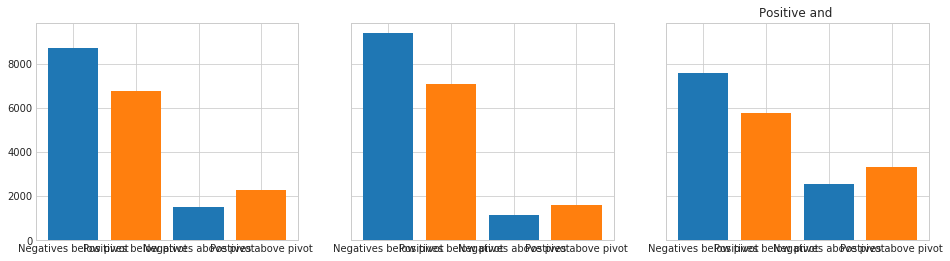

In [17]:
f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 4))
i = 0

for k, d in d_stocks.items():
    pivot = df_scores[df_scores['stock'] == k]['pivot'].values[0]
    df = d[d['queue_imbalance'] < pivot]
    confusion_matrix1 = metrics.confusion_matrix(df['mid_price_indicator'], df['pred_log'])
    ax[i].bar(height = confusion_matrix1.ravel(), x=['Negatives below pivot','Positives below pivot',
                                                     'Negatives above pivot','Postives above pivot'])
    df = d[d['queue_imbalance'] > pivot]
    confusion_matrix2 = metrics.confusion_matrix(df['mid_price_indicator'], df['pred_log'])
    ax[i].bar(height = confusion_matrix2.ravel(), x=['Negatives below pivot','Positives below pivot',
                                                     'Negatives above pivot','Postives above pivot'])
    i += 1
plt.title('Positive and ')